In [230]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
from statistics import mean
from scipy.stats import pearsonr

#sns.set(style='whitegrid', palette='pastel', color_codes=True)
#sns.mpl.rc('figure', figsize=(10,6))

In [161]:
FCC_df = pd.read_csv(r'C:\Users\Ping\Desktop\Ping\DataKind_Data_Dive_Broadband_Access\fcc_477_census_tract_NY.csv')

<AxesSubplot:>

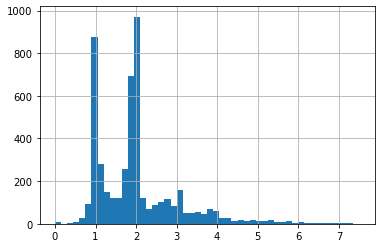

In [4]:
FCC_df['dn100'].hist(bins = 50)
# Observation that FCC dn100 etc. fields have a discrete quality - suggesting tendency to uniformity across each census tract?

In [254]:
ookla_df = pd.read_csv(r'C:\Users\Ping\Desktop\Ping\DataKind_Data_Dive_Broadband_Access\ookla_combined_ny.csv') 
ookla_df.head 
ookla_df.columns 
ookla_df.size

8450649

In [255]:
# Remove NaN's but in this case there don't appear to be any
ookla_df1 = ookla_df[:][ookla_df.avg_d_kbps.isnull()==False]

# Manual weighted average by devices
ookla_df1.loc[:,'temp1'] = ookla_df1.avg_d_kbps*ookla_df1.devices
GEOIDs = ookla_df.GEOID.unique()
d_kbps = [None]*len(GEOIDs)
n_quadkeys = [None]*len(GEOIDs)
n_tests = [None]*len(GEOIDs)
for ind in range(0,len(GEOIDs)):
    sub = ookla_df1[ookla_df1['GEOID']==GEOIDs[ind]]
    n_quadkeys[ind] = len(sub)
    n_tests[ind] = sub['tests'].sum();
    if sub['temp1'].sum()==0 :
        d_kbps[ind] = None     # to prevent zero divide by zero
    else:        
        d_kbps[ind] = sub['temp1'].sum()/sub['devices'].sum()    
    

In [256]:
list_of_tuples = list(zip(GEOIDs, d_kbps, n_tests))
ookla_GEOID = pd.DataFrame(list_of_tuples, columns = ['GEOID','avg_avg_d_kbps','num_tests'])

In [257]:
ookla_GEOID

,GEOID,avg_avg_d_kbps,num_tests
0,36103170202,156808.183932,172479
1,36063024502,162651.432359,1237487
2,36047092400,210133.765027,1252
3,36029014702,124677.289109,1843
4,36029007302,125097.184773,8008
...,...,...,...
3886,36055009200,105425.000000,4
3887,36005000100,89711.600000,13
3888,36055980100,29666.000000,4
3889,36081049200,47160.000000,2


In [258]:
# Exploratory analysis

# Bias in the data availability?

# Are more affluent areas more likely to run more speedtests (normalized to population), e.g., due to higher availability of computers and internet and/or awareness of availability of speedtest (which may be higher among technical professionals who are well paid)

ACS_df = pd.read_csv(r'C:\Users\Ping\Desktop\Ping\DataKind_Data_Dive_Broadband_Access\acs_2019_NY.csv')
ACS_df = ACS_df.loc[:, :'population']
ACS_df.columns

# Remove negative numbers

Index(['state', 'county', 'tract', 'geoid', 'f_broadband', 'f_computer',
       'f_ba', 'f_black', 'f_hispanic', 'log_mhi', 'mhi', 'population'],
      dtype='object')

In [259]:
merged = pd.merge(ACS_df,ookla_GEOID,left_on='geoid',right_on='GEOID',how='left')
merged = merged.loc[merged['population']!=0,:]

In [260]:
merged['tests_per_pop'] = merged.apply(lambda row: row['num_tests'] / row['population'], axis=1)
merged = merged.loc[merged['mhi']>0,:]

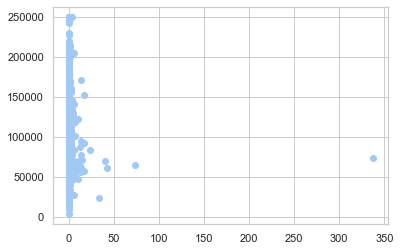

In [261]:
plt.scatter(merged.tests_per_pop, merged.mhi)

In [262]:
# Need to remove outliers
Q1 = merged.tests_per_pop.quantile(q=.25)
Q3 = merged.tests_per_pop.quantile(q=.75)
IQR = Q3-Q1

data = merged['tests_per_pop']
merged['tests_per_pop']= data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR)))]
merged = merged.loc[merged['tests_per_pop'].isnull()==False,:]

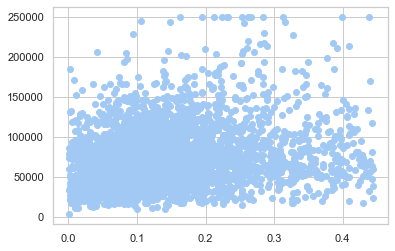

In [263]:
plt.scatter(merged.tests_per_pop, merged.mhi)

In [264]:
corr,p = pearsonr(merged.tests_per_pop, merged.mhi)

In [252]:
p

3.173841565535105e-36

In [253]:
corr

0.2118580852152207

In [ ]:
# Significant positive relationship between MHI and tests/population?